<a href="https://colab.research.google.com/github/288756/VisArtificial/blob/master/Aprofundo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
from google.colab import drive
from sklearn.preprocessing import LabelEncoder
import os
from PIL import Image
import tensorflow as tf
from tensorflow.data import Dataset
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
!pip install tensorflow_addons
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Montar el Google Drive en el directorio del proyecto y descomprimir el fichero con los datos
drive.mount('/content/gdrive')
!unzip -n '/content/gdrive/My Drive/aprendizaje-profundo.zip' >> /dev/null  # ACTUALIZAR: ruta al fichero comprimido


Mounted at /content/gdrive


Primero, se obtienen las rutas donde están almacenados los datos y se guardan como variables. Una vez hecho esto, se extraen los dataframes asociados a esas direcciones y se almacenan también.

In [5]:
data_path = '/content/NIPS4B'
audiostrain_dir = data_path + "/train/"
csvtrain_file = data_path + "/train.csv"

imgtest_dir = data_path + "/test/"
csvtest_file = data_path + "/test.csv"

class_infodir = data_path + "/class_info.csv"

class_info = pd.read_csv(class_infodir)
dftrain = pd.read_csv(csvtrain_file)
dftest = pd.read_csv(csvtest_file)
dftrain

,filename,start,end,class
0,nips4b_train001.wav,2.975057,3.172426,Petpet_song
1,nips4b_train001.wav,1.967891,2.054966,Sylcan_song
2,nips4b_train001.wav,0.856236,0.937506,Sylcan_song
3,nips4b_train001.wav,1.541224,1.674739,Sylcan_song
4,nips4b_train001.wav,1.843084,1.973696,Sylcan_song
...,...,...,...,...
4583,nips4b_train525.wav,3.662041,3.707755,Poepal_call
4584,nips4b_train525.wav,3.732245,3.877551,Poepal_call
4585,nips4b_train525.wav,4.236735,4.337959,Poepal_call
4586,nips4b_train525.wav,2.091429,2.210612,Unknown


Al observar el dataframe de entrenamiento, podemos apreciar que consta de 4 columnas: en la primera sale el nombre del archivo al que pertenece cada fragmento de canto, las dos siguientes son el inicio y el fin del canto y la última es la relacionada con la clase de ave que emite el canto.


Posteriormente, queremos averiguar el número de clases total que tenemos, también se creará una nueva columna que represente la duración del canto, este dato será relevante para el entrenamiento.

In [10]:
clases = class_info['class name']
clasestotal = clases.to_list()
len(clasestotal)

89

In [11]:
# Calcular la duración de los segmentos de canto
dftrain['duration'] = dftrain['end'] - dftrain['start']
dftrain

,filename,start,end,class,duration
0,nips4b_train001.wav,2.975057,3.172426,Petpet_song,0.197370
1,nips4b_train001.wav,1.967891,2.054966,Sylcan_song,0.087075
2,nips4b_train001.wav,0.856236,0.937506,Sylcan_song,0.081270
3,nips4b_train001.wav,1.541224,1.674739,Sylcan_song,0.133515
4,nips4b_train001.wav,1.843084,1.973696,Sylcan_song,0.130612
...,...,...,...,...,...
4583,nips4b_train525.wav,3.662041,3.707755,Poepal_call,0.045714
4584,nips4b_train525.wav,3.732245,3.877551,Poepal_call,0.145306
4585,nips4b_train525.wav,4.236735,4.337959,Poepal_call,0.101224
4586,nips4b_train525.wav,2.091429,2.210612,Unknown,0.119184


Como indica la salida, hay 89 clases diferentes. Algo indispensable antes de abordar la creación de un modelo es asegurarse de que no hay presentes valores nulos en nuestros datos:

In [8]:
missing_data = dftrain.isnull().sum()
print("Datos nulos: ")
print(missing_data)
# Contar la cantidad de muestras por clase
class_counts = dftrain['class'].value_counts()
print("Número de muestras por clase:")
print(class_counts)

Datos nulos: 
filename    0
start       0
end         0
class       0
dtype: int64
Número de muestras por clase:
class
Sylcan_song    201
Unknown        194
Sylund_song    191
Sylmel_call    180
Lularb_song    175
              ... 
Plasab_song      9
Phycol_call      9
Cicorn_song      9
Jyntor_song      9
Cicatr_song      7
Name: count, Length: 89, dtype: int64


No hay presente ningún dato pérdido, también podemos observar las clases con más muestras y con menos en los datos de entrenamiento.

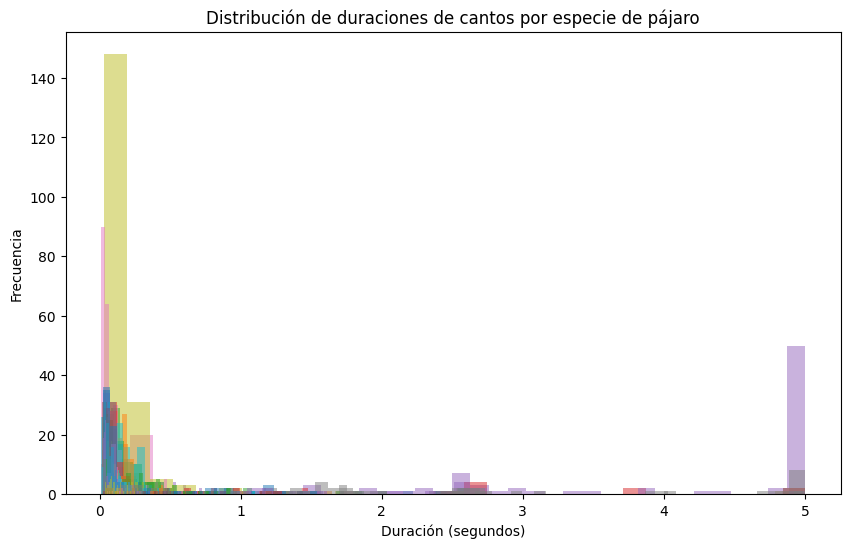

In [12]:
# Histograma de las duraciones de los cantos para cada clase
plt.figure(figsize=(10, 6))
for species in dftrain['class'].unique():
    durations = dftrain[dftrain['class'] == species]['duration']
    plt.hist(durations, bins=30, alpha=0.5, label=species)
plt.xlabel('Duración (segundos)')
plt.ylabel('Frecuencia')
plt.title('Distribución de duraciones de cantos por especie de pájaro')
plt.show()

In [ ]:
label_encoder = LabelEncoder()
dftrain['class'] = label_encoder.fit_transform(dftrain['class'])

import librosa
import librosa.display
import matplotlib.pyplot as plt
import os


def generate_spectrograms(dataframe, audio_dir, n_fft=256, hop_length=128, n_mels=32, fmax=8000):
    spectrograms = []
    lengths = []

    for index, row in dataframe.iterrows():
        audio_file = os.path.join(audio_dir, row['filename'])
        start_time = row['start']
        end_time = row['end']

        try:
            # Cargar el archivo de audio
            y, sr = librosa.load(audio_file, sr=None, offset=start_time, duration=end_time - start_time)

            # Calcular el espectrograma de Mel
            spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmax=fmax)

            # Convertir a dB
            spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

            # Guardar la longitud del espectrograma
            lengths.append(spectrogram_db.shape[1])

            # Agregar el espectrograma a la lista junto con la clase y otra información relevante
            spectrograms.append((spectrogram_db, row['class'], start_time, end_time))

        except Exception as e:
            print(f"Error processing {audio_file}: {e}")

    # Calcular la longitud media
    mean_length = int(np.mean(lengths))

    # Ajustar los espectrogramas a la longitud media
    adjusted_spectrograms = []
    for spectrogram, label, start_time, end_time in spectrograms:
        if spectrogram.shape[1] < mean_length:
            # Padding
            pad_width = mean_length - spectrogram.shape[1]
            spectrogram_padded = np.pad(spectrogram, ((0, 0), (0, pad_width)), mode='constant')
        else:
            # Recortar
            spectrogram_padded = spectrogram[:, :mean_length]

        adjusted_spectrograms.append((spectrogram_padded, label, start_time, end_time))

    return adjusted_spectrograms, mean_length

In [ ]:
# Ejemplo simplificado de cómo podrías generar espectrogramas con duración
adjusted_spectrograms, mean_length = generate_spectrograms(dftrain, audiostrain_dir, n_fft=256, hop_length=128)

# Asegúrate de que cada espectrograma tenga su duración correspondiente
for idx, (spec, label, start_time, end_time) in enumerate(adjusted_spectrograms):
    duration = dftrain.iloc[idx]['duration']
    adjusted_spectrograms[idx] = (spec, label, start_time, end_time, duration)


In [ ]:
# Verificar tamaños de los espectrogramas
def check_spectrogram_sizes(adjusted_spectrograms):
    shapes = [spectrogram.shape for spectrogram, _, _, _, _ in adjusted_spectrograms]
    unique_shapes = set(shapes)
    return unique_shapes

# Llamar a la función y verificar
unique_shapes = check_spectrogram_sizes(adjusted_spectrograms)

if len(unique_shapes) == 1:
    print(f"Todos los espectrogramas tienen el mismo tamaño: {unique_shapes.pop()}")
else:
    print(f"Los espectrogramas tienen diferentes tamaños: {unique_shapes}")


Todos los espectrogramas tienen el mismo tamaño: (32, 92)


Tamaño de los datos de entrada: (4588, 32, 92)
Tamaño de las etiquetas: (4588,)


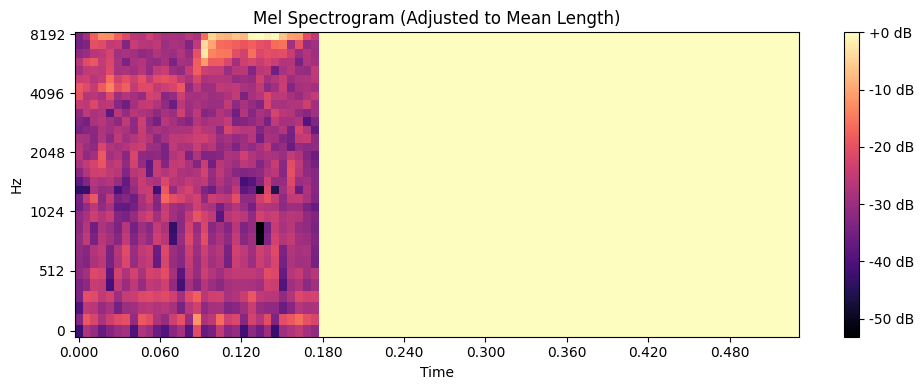

In [ ]:
# Convertir a un formato numpy adecuado para el entrenamiento
X = np.array([item[0] for item in adjusted_spectrograms])
y = np.array([item[1] for item in adjusted_spectrograms])

print(f"Tamaño de los datos de entrada: {X.shape}")
print(f"Tamaño de las etiquetas: {y.shape}")

# Verificación visual de un espectrograma
plt.figure(figsize=(10, 4))
librosa.display.specshow(X[1], hop_length=128, x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram (Adjusted to Mean Length)')
plt.tight_layout()
plt.show()

In [ ]:
adjusted_spectrograms

[(array([[-14.0602455, -14.332943 , -13.267918 , ...,   0.       ,
            0.       ,   0.       ],
         [ -5.213375 ,  -5.4860764,  -4.421051 , ...,   0.       ,
            0.       ,   0.       ],
         [-15.729046 , -18.568386 ,  -6.054508 , ...,   0.       ,
            0.       ,   0.       ],
         ...,
         [-14.073887 , -14.507931 , -17.012547 , ...,   0.       ,
            0.       ,   0.       ],
         [-18.891804 , -17.371212 , -17.993847 , ...,   0.       ,
            0.       ,   0.       ],
         [-23.02277  , -16.369343 , -17.179028 , ...,   0.       ,
            0.       ,   0.       ]], dtype=float32),
  52,
  2.975056689,
  3.172426304,
  0.19736961499999994),
 (array([[-41.9934  , -27.778015, -30.874352, ...,   0.      ,   0.      ,
            0.      ],
         [-33.14653 , -18.931145, -22.027485, ...,   0.      ,   0.      ,
            0.      ],
         [-39.313927, -25.61118 , -26.332909, ...,   0.      ,   0.      ,
            0.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input

# Asumiendo que `adjusted_spectrograms` contiene los espectrogramas ajustados con sus etiquetas de duración y clase

# Preparar datos para el modelo
X = np.array([spec for spec, label, _, _, _ in adjusted_spectrograms])
y_duration = np.array([duration for _, _, _, _, duration in adjusted_spectrograms])
y_class = np.array([label for _, label, _, _, _ in adjusted_spectrograms])

# Dividir en conjuntos de entrenamiento y prueba para ambas tareas
from sklearn.model_selection import train_test_split
X_train, X_test, y_duration_train, y_duration_test, y_class_train, y_class_test = train_test_split(X, y_duration, y_class, test_size=0.2, random_state=42)

# Añadir una dimensión de canal para que sea compatible con Conv2D
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Construcción del modelo CNN
input_shape = X_train.shape[1:]

# Capas de entrada
inputs = Input(shape=input_shape)

# Primera capa convolucional
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Segunda capa convolucional
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Tercera capa convolucional
x = Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Capas completamente conectadas para la salida de duración
x_duration = Flatten()(x)
x_duration = Dense(256, activation='relu')(x_duration)
x_duration = Dropout(0.5)(x_duration)
x_duration = BatchNormalization()(x_duration)
output_duration = Dense(1, name='output_duration')(x_duration)

# Capas completamente conectadas para la salida de clase
x_class = Flatten()(x)
x_class = Dense(256, activation='relu')(x_class)
x_class = Dropout(0.5)(x_class)
x_class = BatchNormalization()(x_class)
output_class = Dense(89, activation='softmax', name='output_class')(x_class)  # num_species es el número de clases de aves

# Modelo final
model = Model(inputs=inputs, outputs=[output_duration, output_class])

# Compilación del modelo con pérdidas y métricas específicas para cada salida
model.compile(optimizer='adam',
              loss={'output_duration': 'mse', 'output_class': 'sparse_categorical_crossentropy'},
              metrics={'output_duration': 'mae', 'output_class': 'accuracy'})

# Implementación de Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento del modelo
history = model.fit(X_train, {'output_duration': y_duration_train, 'output_class': y_class_train},
                    epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

loss_and_metrics = model.evaluate(X_test, {'output_duration': y_duration_test, 'output_class': y_class_test})
print(f"Test Loss: {loss_and_metrics[0]}")
print(f"Test MAE: {loss_and_metrics[3]}")
print(f"Test Accuracy: {loss_and_metrics[4]}")

Epoch 1/100
92/92 [==============================] - 38s 26ms/step - loss: 6.2802 - output_duration_loss: 1.7960 - output_class_loss: 4.4842 - output_duration_mae: 0.9966 - output_class_accuracy: 0.0674 - val_loss: 4.6406 - val_output_duration_loss: 0.5597 - val_output_class_loss: 4.0809 - val_output_duration_mae: 0.5243 - val_output_class_accuracy: 0.0886
Epoch 2/100
92/92 [==============================] - 1s 10ms/step - loss: 5.0540 - output_duration_loss: 1.0034 - output_class_loss: 4.0506 - output_duration_mae: 0.7246 - output_class_accuracy: 0.0943 - val_loss: 4.3400 - val_output_duration_loss: 0.3710 - val_output_class_loss: 3.9690 - val_output_duration_mae: 0.2824 - val_output_class_accuracy: 0.0981
Epoch 3/100
92/92 [==============================] - 1s 9ms/step - loss: 4.5790 - output_duration_loss: 0.7429 - output_class_loss: 3.8362 - output_duration_mae: 0.5971 - output_class_accuracy: 0.1281 - val_loss: 4.2789 - val_output_duration_loss: 0.4383 - val_output_class_loss: 3.8

In [ ]:
import os
import pandas as pd
import librosa
import numpy as np

# Ruta al directorio de archivos de prueba y archivo CSV de prueba
test_data_path = '/content/NIPS4B/test/'
test_csv_file = '/content/NIPS4B/test.csv'

# Leer el archivo CSV de prueba
test_df = pd.read_csv(test_csv_file)

# Función para generar múltiples espectrogramas de la misma longitud para archivos de prueba
def generate_test_spectrograms(test_df, test_data_path, mean_length, num_segments=10, n_fft=256, hop_length=128, n_mels=32, fmax=8000):
    spectrograms = []
    filenames = []
    segment_start_times = []
    segment_end_times = []

    for index, row in test_df.iterrows():
        audio_file = os.path.join(test_data_path, row['filename'])

        try:
            # Cargar el archivo de audio completo
            y, sr = librosa.load(audio_file, sr=None)

            # Dividir el audio en segmentos
            segment_duration = len(y) / num_segments
            segment_starts = np.arange(0, len(y), int(segment_duration))

            for start in segment_starts:
                end = int(start + segment_duration)
                y_segment = y[start:end]

                # Calcular el espectrograma de Mel
                spectrogram = librosa.feature.melspectrogram(y=y_segment, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmax=fmax)

                # Convertir a dB
                spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

                # Ajustar el espectrograma a la longitud media
                if spectrogram_db.shape[1] < mean_length:
                    # Padding
                    pad_width = mean_length - spectrogram_db.shape[1]
                    spectrogram_padded = np.pad(spectrogram_db, ((0, 0), (0, pad_width)), mode='constant')
                else:
                    # Recortar
                    spectrogram_padded = spectrogram_db[:, :mean_length]

                # Guardar el espectrograma, el nombre del archivo y los tiempos de inicio y fin del segmento
                spectrograms.append(spectrogram_padded)
                filenames.append(row['filename'])
                segment_start_times.append(start / sr)  # Convertir a tiempo en segundos
                segment_end_times.append(end / sr)      # Convertir a tiempo en segundos

        except Exception as e:
            print(f"Error processing {audio_file}: {e}")

    return np.array(spectrograms), filenames, segment_start_times, segment_end_times

# Obtener espectrogramas, nombres de archivo y tiempos de inicio/fin de segmento de prueba
num_segments = 5  # Número de segmentos por archivo de prueba
test_spectrograms, test_filenames, test_segment_start_times, test_segment_end_times = generate_test_spectrograms(test_df, test_data_path, mean_length, num_segments)

# Añadir una dimensión de canal para que sea compatible con Conv2D
test_spectrograms = test_spectrograms[..., np.newaxis]


# Predecir con el modelo entrenado
predictions_duration, predictions_class = model.predict(test_spectrograms)


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=256 is too large for input signal of length=2
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=256 is too large for input signal of length=1
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=256 is too large for input signal of length=3
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=256 is too large for input signal of length=4
  warnings.warn(


28/28 [==============================] - 0s 9ms/step


In [ ]:
predicted_classes = np.argmax(predictions_class, axis=1)
if len(predicted_classes) == len(predictions_duration):
  print(True)
#Esta función encuentra el índice del valor máximo a lo largo del eje 1 (columnas) de predictions_class. En otras palabras, para cada fila (que representa un segmento de audio), argmax devuelve el índice de la clase con la probabilidad más alta.

True


In [ ]:
for i in predictions_duration:
  if i < 0:
    print(i)

In [ ]:
dftrain['class']

0       52
1       76
2       76
3       76
4       76
        ..
4583    59
4584    59
4585    59
4586    88
4587    59
Name: class, Length: 4588, dtype: int64

In [ ]:
# Inicializar el DataFrame de resultados
label_encoder = LabelEncoder()
label_encoder.fit(y_class)  # Asegúrate de que y_class contiene todas las etiquetas de clases
class_labels = label_encoder.classes_
results_df = pd.DataFrame(columns=['filename'] + list(class_labels))

# Inicializar las filas del DataFrame de resultados
for i in range(len(test_df)):
    filename_predictions = [test_df.at[i, 'filename']] + [0.0] * len(class_labels)
    results_df.loc[i] = filename_predictions

# Calcular la duración total para cada clase y archivo
for i, filename in enumerate(test_filenames):
    filename_index = results_df[results_df['filename'] == filename].index[0]

    # Obtener las predicciones de clase y duración para todos los segmentos de este archivo
    segment_indices = [idx for idx, f in enumerate(test_filenames) if f == filename]
    for idx in segment_indices:
        predicted_class = np.argmax(predictions_class[idx])
        predicted_duration = predictions_duration[idx][0]
        class_label = label_encoder.inverse_transform([predicted_class])[0]

        if predicted_duration >= 0:
            # Sumar la duración predicha a la clase correspondiente en el DataFrame de resultados
            results_df.at[filename_index, class_label] += predicted_duration

# Mostrar el DataFrame de resultados
results_df.columns = ['filenames'] + clasestotal
# Guardar los resultados en un archivo CSV
results_csv_file = '/content/NIPS4B/results.csv'
results_df.to_csv(results_csv_file, index=False)

print("Resultados guardados en", results_csv_file)

Resultados guardados en /content/NIPS4B/results.csv
